In [ ]:
import numpy as np
from matplotlib import pyplot
import threading
import pickle
import argparse
import logging
import os
import random
import pprint
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
np.set_printoptions(suppress=True)


In [ ]:
with open("points.pickle",'rb') as pf:
    data = pickle.load(pf)
print(data[1])

In [ ]:
board = [[0 for _ in range(28)] for _ in range(28)]
for k,v in data.items():
    v = list(set(v))
    for x,y in v:
        board[x][y] += 1/len(data)

data = {k:v for k,v in data.items() if len(list(set(v)))>0}

df = pd.DataFrame(np.array(board).reshape(28,28))
p1 = sns.heatmap(df)

points_sum = 0
for k,v in data.items():
    v = list(set(v))
    points_sum += len(v)
print(points_sum/len(data))

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_processed = x_train.astype("float32") / 255 / len(data)
num_board = np.array([[0 for _ in range(28)] for _ in range(28)]).astype(np.float32)
for k,v in data.items():
    num_board = np.add(x_processed[k], num_board)
df = pd.DataFrame(np.array(num_board).reshape(28,28))
p1 = sns.heatmap(df)

In [ ]:
modified = [[[0 for _ in range(28)] for _ in range(28)] for _ in range(10)]
original = [pd.DataFrame(np.array([[0 for _ in range(28)] for _ in range(28)]).reshape(28,28)) for _ in range(10)]
numer_stat = {i:0 for i in range(10)}
for k,v in data.items():
    numer_stat[y_train[k]] += 1

print(numer_stat)

for k,v in data.items():
    v = list(set(v))
    number = y_train[k]
    for x,y in v:
        modified[number][x][y] += 1/numer_stat[number]
    original[number] = np.add(original[number], x_processed[k])
    

for i in range(1):
    sns.heatmap(pd.DataFrame(original[i]))
    pyplot.show()
    sns.heatmap(pd.DataFrame(modified[i]))
    pyplot.show()


In [109]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

slice_points = 7
input_shape = (28, 28, 1)
output_shape = (5,2,28)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

ad_x = []
ad_y  = []
for k,v in data.items():
    v = list(set(v))
    ad_x.append(x_train[k])
    v = v*slice_points
    arr = np.zeros(shape=(28,28), dtype=float)
    for i in range(slice_points):
        arr[v[i][0]][v[i][1]] = 1
    ad_y.append(arr)

ad_x = np.expand_dims(ad_x, -1)
ad_y = np.array(ad_y)
ad_y = np.expand_dims(ad_y, -1)


print(ad_x.shape)
print(ad_y.shape)

admodel = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(28*28*1),
        layers.Reshape((28, 28, 1)),
    ]
)

print("Model output", admodel.output_shape)
admodel.summary()

# """
# ## Train the model
# """

batch_size = 128
epochs = 5

admodel.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
admodel.fit(ad_x, ad_y, batch_size=batch_size, epochs=epochs, validation_split=0.2)



(6975, 28, 28, 1)
(6975, 28, 28, 1)
Model output (None, 28, 28, 1)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 4608)              0         
                                                                 
 dropout_20 (Dropout)        (None, 4608)              0         
                                                                 
 dense_19 (Dense)            (None, 784)               3613456   
                                                                 
 reshape_14 (Reshape)        (None, 28, 28, 1)      

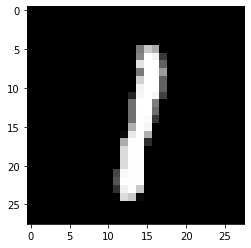

<AxesSubplot:>

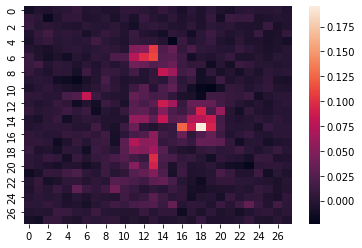

In [111]:
admodel.save('admnist.h5')
pyplot.imshow(x_train[1200], cmap=pyplot.get_cmap('gray'))
pyplot.show()
predictions = admodel.predict(np.expand_dims(x_train[1200], axis=0))[0]
sns.heatmap(pd.DataFrame(predictions.reshape(28,28), index=[i for i in range(28)], columns=[i for i in range(28)]))

In [ ]:
multiply_factors = [] 
model = keras.models.load_model('mnist.h5')

for sample_num in range(60000):
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    for multiply_factor in range(1,500):
        print(multiply_factor, end="    \r")
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        # print(model.predict(np.expand_dims(attacked_image, axis=0))[0][y_train[sample_num]])
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax() != model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            multiply_factors.append(multiply_factor)
            print(multiply_factor)
            # file_to_store = open(f"multiply_factors.pickle", "wb")
            # pickle.dump(multiply_factors, file_to_store)
            # file_to_store.close()
            break

# with open("multiply_factors.pickle",'rb') as pf:
#     multiply_factors = pickle.load(pf)
# print(sum(multiply_factors)/len(multiply_factors))

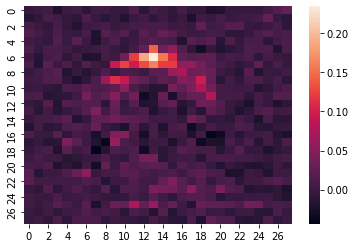

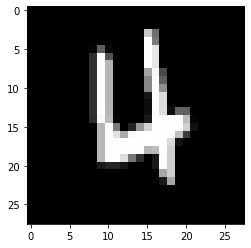

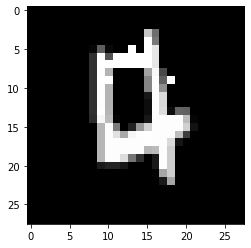

Original  4 Now  8 Multiply_factor 11


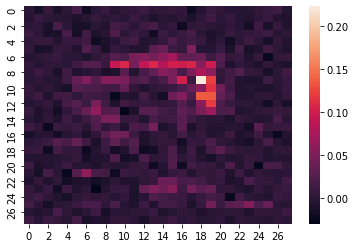

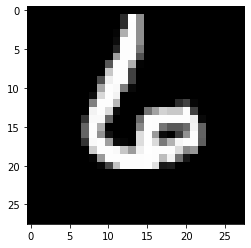

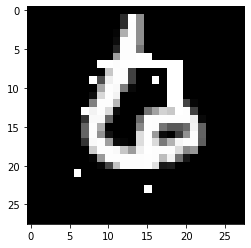

Original  6 Now  0 Multiply_factor 18


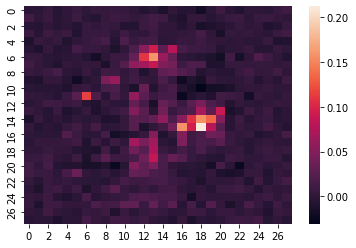

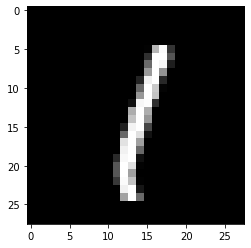

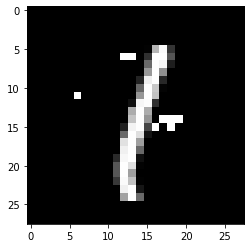

Original  1 Now  7 Multiply_factor 10


In [141]:
def adaptive_attack(sample_num):
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    sns.heatmap(pd.DataFrame(admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28), index=[i for i in range(28)], columns=[i for i in range(28)]))
    pyplot.show()
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            pyplot.imshow(x_train[sample_num], cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            pyplot.imshow(attacked_image, cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            print("Original ", model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax(), "Now ", model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax(), "Multiply_factor", multiply_factor)
            return
    print("multiply_factor reached 300, can't trigger attack")

for i in range(3):
    adaptive_attack(random.randint(0, 60000))


In [ ]:
np.set_printoptions(suppress=False)
model = keras.models.load_model('mnist.h5')

from tqdm import tqdm 
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
y_train = [0 for _ in range(len(x_train))]
y_test = [0 for _ in range(len(x_test))]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
for i in tqdm(range(len(x_train))):
    y_train[i] = model.predict(np.expand_dims(x_train[i], axis=0))[0]
for i in tqdm(range(len(x_test))):
    y_test[i] = model.predict(np.expand_dims(x_train[i], axis=0))[0]
print(y_train[0])

model.predict(np.expand_dims(x_train[12], axis=0))[0]

In [123]:
# file_to_store = open(f"y_train.pickle", "wb")
# pickle.dump(y_train, file_to_store)
# file_to_store.close()
# file_to_store = open(f"y_test.pickle", "wb")
# pickle.dump(y_test, file_to_store)
# file_to_store.close()
with open("y_test.pickle", 'rb') as f:
    y_test = pickle.load(f)
with open("y_train.pickle", 'rb') as f:
    y_train = pickle.load(f)

In [133]:
y_train = np.array(y_train)
y_test = np.array(y_test)
dismodel = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)

print("Model output", dismodel.output_shape)
dismodel.summary()

# """
# ## Train the model
# """

batch_size = 128
epochs = 5

dismodel.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
dismodel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.5)
dismodel.save('dismnist.h5')


Model output (None, 10)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_41 (Flatten)        (None, 1600)              0         
                                                                 
 dropout_36 (Dropout)        

[1.8107850e-11 2.7473806e-07 4.2569755e-07 5.5906617e-06 3.4349390e-13
 3.9189835e-11 1.4915251e-17 9.9999321e-01 1.0969632e-07 3.4083357e-07]
[-0.02290087  0.0911199   0.01378534  0.0289527  -0.02751233 -0.01056611
 -0.00684423  0.9512222  -0.01259873 -0.02854712]


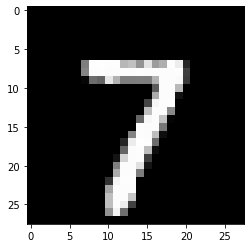

[8.9683553e-08 9.9966419e-01 3.4123441e-06 7.2842990e-06 8.6480963e-05
 6.5164031e-06 8.3483957e-07 9.0820631e-06 2.1918163e-04 2.9146797e-06]
[-0.00281201  0.9109292  -0.03218349  0.01862105  0.00186234  0.02838589
  0.02738314  0.00333152  0.00684594  0.05000812]


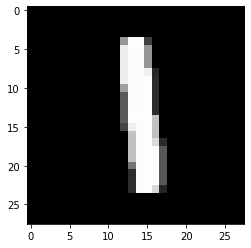

[5.2116275e-07 1.9862461e-04 3.8684128e-05 5.9161143e-06 4.6490635e-07
 5.4968274e-07 2.7281838e-11 9.9932182e-01 2.0839753e-04 2.2498939e-04]
[-2.03888230e-02  1.44793242e-02  2.05612659e-01 -9.33542997e-02
  2.26490316e-04  6.00692444e-03 -5.79888783e-02  7.07972765e-01
  1.23004586e-01  1.18322074e-01]


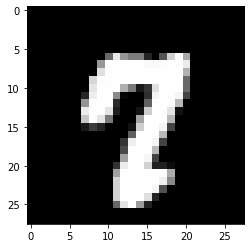

In [139]:
for i in range(3):
    sample_num = random.randint(0, 60000)
    print(model.predict(np.expand_dims(x_train[sample_num], axis=0))[0])
    print(dismodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0])
    pyplot.imshow(x_train[sample_num], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

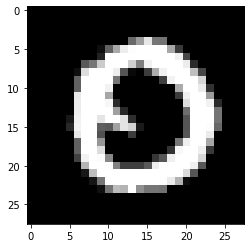

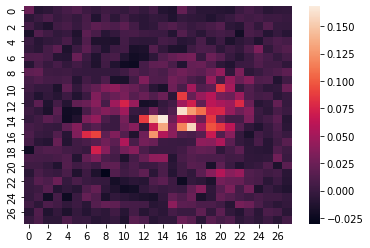

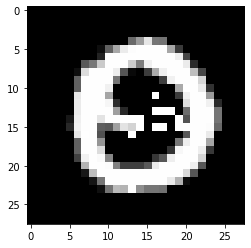

Original  0 Now  8 Multiply_factor original model 12


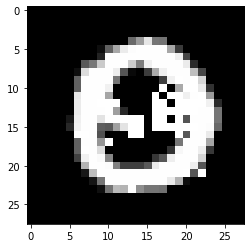

Original  0 Now  8 Multiply_factor distillation model 23


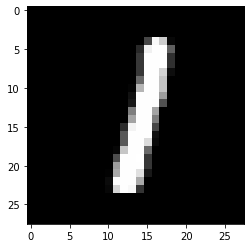

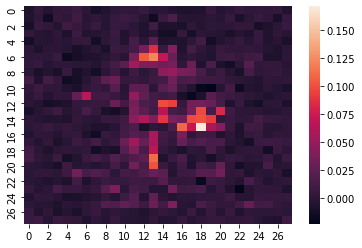

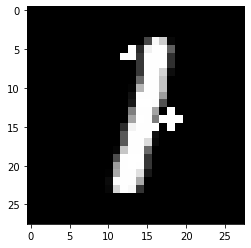

Original  1 Now  7 Multiply_factor original model 12


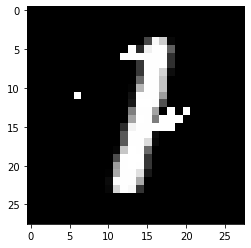

Original  1 Now  7 Multiply_factor distillation model 15


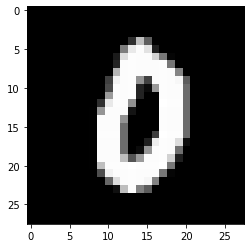

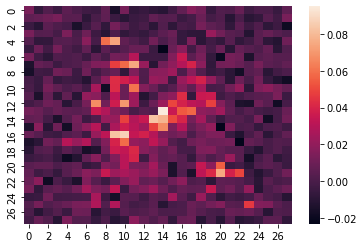

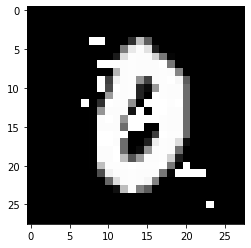

Original  0 Now  2 Multiply_factor original model 26


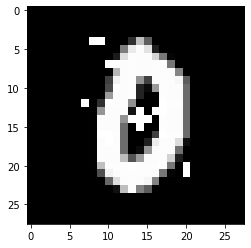

Original  0 Now  0 Multiply_factor distillation model 20


In [149]:
def adaptive_attack_dis(sample_num):
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    pyplot.imshow(x_train[sample_num], cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    sns.heatmap(pd.DataFrame(admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28), index=[i for i in range(28)], columns=[i for i in range(28)]))
    pyplot.show()
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            pyplot.imshow(attacked_image, cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            print("Original ", model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax(), "Now ", model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax(), "Multiply_factor original model", multiply_factor)
            break
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1       
        if dismodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=dismodel.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            pyplot.imshow(attacked_image, cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            print("Original ", model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax(), "Now ", model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax(), "Multiply_factor distillation model", multiply_factor)
            break

for i in range(3):
    adaptive_attack_dis(random.randint(0, 60000))

In [157]:
original_model_factors = []
distillation_model_factors = []

for i in range(600):
    sample_num = random.randint(0, 60000)
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            original_model_factors.append(multiply_factor)
            break
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1       
        if dismodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=dismodel.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            distillation_model_factors.append(multiply_factor)
            break
    print( "Checking ", i,  "original model factor:", int(sum(original_model_factors)/len(original_model_factors)), "distillation model factor:" ,
            int(sum(distillation_model_factors)/len(distillation_model_factors)), end="           \r")